## **Generating song lyrics using LSTM**


**

### Importing the relevant libraries

In [ ]:
#libraries to import and view data
import pandas as pd
import numpy as np

In [ ]:
#for visualisation of the data at hand
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
#for building the model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import gensim 

In [ ]:
#for saving best model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#for storing the created data
from keras.models import load_model
import pickle

### Loading the data and initial impressions

In [ ]:
#Mounting account's drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading the data from file
df_initial = pd.read_csv("/content/drive/MyDrive/CSCI6364Proj/lyrics-data.csv")

In [ ]:
df_initial.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [ ]:
df_initial.shape

(379931, 5)

In [ ]:
df_filtered = df_initial[df_initial['ALink'].isin(["/twenty-one-pilots/","/queen/","/ac-dc/","/abba/"])]

In [ ]:
# value count of language types
df_filtered['language'].value_counts()

en    641
es     19
sv     12
de      2
pt      1
fr      1
hu      1
it      1
Name: language, dtype: int64

In [ ]:
total_len = len(df_filtered) #obtaining the initial number of lyrics from all languages
en_len = len(df_filtered[df_filtered['language']=='en']) #obtaining the number of english lyrics
print('The percentage of english songs is {}% (approx)'. format(round((en_len/total_len)*100)))

The percentage of english songs is 91% (approx)


### Cleaning and Visualising the data

At first, we drop all the columns from the table that are not neede for the present task. This includes columns Alink, SName, and SLink.

In [ ]:
df_filtered.head()

,ALink,SName,SLink,Lyric,language
27610,/ac-dc/,Back In Black,/ac-dc/back-in-black.html,"Back in black, I hit the sack,\nI've been too ...",en
27611,/ac-dc/,Highway To Hell,/ac-dc/highway-to-the-hell.html,"Living easy, livin' free\nSeason ticket, on a ...",en
27612,/ac-dc/,Thunderstruck,/ac-dc/thunderstruck.html,Ahh-ahh-ahh-ahh-ahh-ahh (x7)\n\nAhh-ahh-ahh-ah...,en
27613,/ac-dc/,You Shook Me All Night Long,/ac-dc/you-shook-me-all-night-long.html,She was a fast machine\nShe kept the motor cle...,en
27614,/ac-dc/,T.N.T.,/ac-dc/t-n-t.html,"Aye, aye, aye, aye, aye,\nAye, aye, aye, aye, ...",en


In [ ]:
df_filtered.drop(['ALink','SName','SLink'],axis=1,inplace=True)
df_filtered.head()

<ipython-input-85-d564517fdd52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(['ALink','SName','SLink'],axis=1,inplace=True)


,Lyric,language
27610,"Back in black, I hit the sack,\nI've been too ...",en
27611,"Living easy, livin' free\nSeason ticket, on a ...",en
27612,Ahh-ahh-ahh-ahh-ahh-ahh (x7)\n\nAhh-ahh-ahh-ah...,en
27613,She was a fast machine\nShe kept the motor cle...,en
27614,"Aye, aye, aye, aye, aye,\nAye, aye, aye, aye, ...",en


For the present application, we focus our attention only to english language songs. Hence we filter out the above dataframe to retain only 50% of the songs - all in english.

In [ ]:
#dropping all non english songs
df = df_filtered[df_filtered['language']=='en']

We now reset the index and create another column that counts the number of distinct words in each song.

In [ ]:
#we now reset the index and drop the language column also
df.reset_index(inplace=True)
df.drop(['language'],axis=1,inplace=True)
df.drop(['index'],axis=1,inplace=True)
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df.head()

<ipython-input-87-4234c44bb30b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['language'],axis=1,inplace=True)
<ipython-input-87-4234c44bb30b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'],axis=1,inplace=True)
<ipython-input-87-4234c44bb30b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str

,Lyric,Number_of_words
0,"Back in black, I hit the sack,\nI've been too ...",263
1,"Living easy, livin' free\nSeason ticket, on a ...",186
2,Ahh-ahh-ahh-ahh-ahh-ahh (x7)\n\nAhh-ahh-ahh-ah...,206
3,She was a fast machine\nShe kept the motor cle...,247
4,"Aye, aye, aye, aye, aye,\nAye, aye, aye, aye, ...",189


### Preparing the data for Text prediction

In [ ]:
# statistical info
df['Number_of_words'].describe()

count    641.000000
mean     225.496100
std       85.429505
min        2.000000
25%      170.000000
50%      215.000000
75%      276.000000
max      565.000000
Name: Number_of_words, dtype: float64

Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

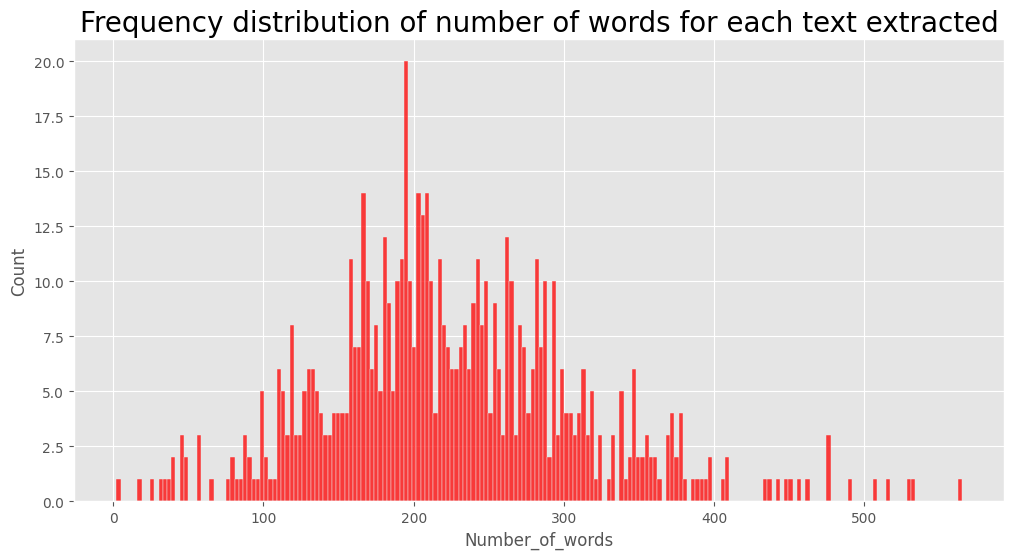

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.histplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [ ]:
df.shape

(641, 2)

Further, we now tokenise the entire dataset and convert the tokenised sentences into n gram sequences.

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())
total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
tokenized_sentences[0]

In [ ]:
#saving the tokenizer for prediction reproducability
with open('/content/drive/MyDrive/CSCI6364Proj/tokenizer-VF2.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[:10]

array([[   0,    0,    0, ...,    0,   55,   10],
       [   0,    0,    0, ...,   55,   10,  249],
       [   0,    0,    0, ...,   10,  249,    3],
       ...,
       [   0,    0,    0, ..., 1944,   86,  101],
       [   0,    0,    0, ...,   86,  101,   95],
       [   0,    0,    0, ...,  101,   95,  125]], dtype=int32)

In [ ]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Building the model

At first, we create a gensim word2vec embedding.

In [ ]:
word_model = gensim.models.Word2Vec(tokenized_sentences)
pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

Result embedding shape: (3349, 100)


We now create and train the LSTM model

In [ ]:
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the model

Creating checkpoints and training model.

In [ ]:
# checkpoint
filepath="/content/drive/MyDrive/CSCI6364Proj/only_four_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
callbacks_list = [checkpoint, es]
history = model.fit(X, y, epochs=200, verbose=1, callbacks=[callbacks_list])

Epoch 1/200
4545/4545 [==============================] - ETA: 0s - loss: 1.5915 - accuracy: 0.6228
Epoch 1: loss improved from inf to 1.59148, saving model to /content/drive/MyDrive/CSCI6364Proj/only_four_model.h5
4545/4545 [==============================] - 318s 70ms/step - loss: 1.5915 - accuracy: 0.6228
Epoch 2/200
4545/4545 [==============================] - ETA: 0s - loss: 1.5603 - accuracy: 0.6282
Epoch 2: loss improved from 1.59148 to 1.56033, saving model to /content/drive/MyDrive/CSCI6364Proj/only_four_model.h5
4545/4545 [==============================] - 318s 70ms/step - loss: 1.5603 - accuracy: 0.6282
Epoch 3/200
4545/4545 [==============================] - ETA: 0s - loss: 1.5287 - accuracy: 0.6343
Epoch 3: loss improved from 1.56033 to 1.52871, saving model to /content/drive/MyDrive/CSCI6364Proj/only_four_model.h5
4545/4545 [==============================] - 319s 70ms/step - loss: 1.5287 - accuracy: 0.6343
Epoch 4/200
4545/4545 [==============================] - ETA: 0s - l

KeyboardInterrupt: ignored

Saving the model

In [ ]:
# save model
model.save('/content/drive/MyDrive/CSCI6364Proj/only_four_model_finalV2.h5')

### Evaluating the model

Plotting the accuracy evolution curve.

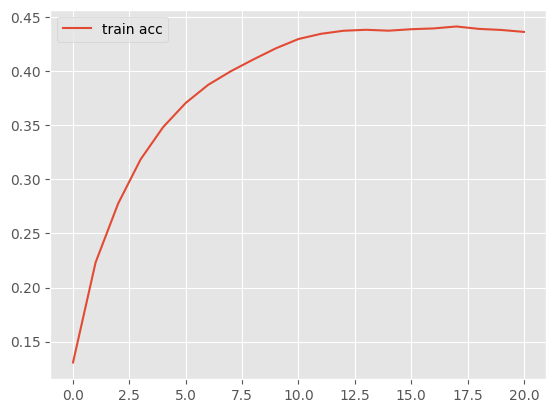

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### Making predictions using the model

At first, we create a function to generate lyrics given an input sequence.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=856, padding='pre')
        predict_x=model.predict(token_list, verbose=0) 
        predicted=np.argmax(predict_x,axis=1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

Some test cases - 

In [ ]:
complete_this_song("the sky is blue", 40)

'the sky is blue and the home is on your back kicked in the street take a chance on a walk on the borderline on the borderline oh oh no ma and the night look out of the door and the night of the'

In [ ]:
complete_this_song("I love you like a love song", 80)

"I love you like a love song yeah i don't know what it mean i think you could be in the corner take a chance to you and i know that you're in any way i can do i don't want to go like you don't know don't you wanna give me that i won't take a little love from your life i want to make you mine i want to break my life i want to break you all i want to make you go ooh"

In [ ]:
complete_this_song("In the end it", 80)

"In the end it was a good time good time i saw a good night drive in the rain never said that i said it's a beautiful world all my way to be found to be where you feel it's the way to make me feel my make you feel call me if you need a touch on me if you need my love call me if you need my love call me if you need my love call me if you need my"

In [ ]:
complete_this_song("the sky is blue", 80)

"the sky is blue and the home is on your back kicked in the street take a chance on a walk on the borderline on the borderline oh oh no ma and the night look out of the door and the night of the fantasy yeah i'm gonna get you a rocket man on a man watch out man on the prowl man you know what a gun for a big man with a big man with a big man with a big man"

### Saving the model and the tokens for reproducability

loading the final model at later stages for testing.

In [ ]:
#loading the model and saved corpus
model = load_model('/content/drive/MyDrive/CSCI6364Proj/only_four_model_finalV2.h5')
#with open('/content/drive/MyDrive/CSCI6364Proj/tokenizerVF.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

In [ ]:
with open('/content/drive/MyDrive/CSCI6364Proj/tokenizer-VF2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Usage

In [2]:
#Mounting account's drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#loading the model and saved corpus
from keras.models import load_model
import pickle
model = load_model('/content/drive/MyDrive/CSCI6364Proj/only_four_model_finalV2.h5')
with open('/content/drive/MyDrive/CSCI6364Proj/tokenizer-VF2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=856, padding='pre')
        predict_x=model.predict(token_list, verbose=0) 
        predicted=np.argmax(predict_x,axis=1)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [14]:
complete_this_song("this is what falling", 180)

"this is what falling how to me how to make you cry my life is been free i want to be free oh so i don't believe 'cause i'm gonna be a good time i can see our lives i have wanted to be heard i would have to choose i wouldn t let you go cause it's a better way to the top i'll be with a ghost i can find me i don't want to be a live or live live to live to live i'm live in a better live live live and i'm a soul i'm a good old little star just a long year i'll be taking on a time on my own dee do i do i'm gonna be a good day i been in the mirror i can see it in your eyes i can see the time i know that i'm hungry and i know i'm gonna be so high lonely let's have it hard to do let's sit back to go i'm trying to say i can't get the best i don't want to stop"